In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import *
import mplcyberpunk
import seaborn
from IPython.display import clear_output
plt.style.use("cyberpunk")


2024-04-19 17:27:01.744073: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-19 17:27:01.780717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 17:27:02.667544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
# Load MNIST data
(x_train, y_train), (x_test, _) = mnist.load_data()

# Normalize data and flatten images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

x_train = x_train[(y_train < 2) | (y_train == 4)]
y_train = y_train[(y_train < 2) | (y_train == 4)]

# Verification subset
y = y_train[:1000]
X = x_train[:1000]
X = X[np.argsort(y)]
y = np.sort(y)

In [12]:
def plot_correlation_matrices(X, L):
    Xcorr = np.corrcoef(X)
    Lcorr = np.corrcoef(L)
    error = np.abs(Xcorr - Lcorr)

    fig, axs = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)

    axs[0].set_title("Input")
    axs[0].imshow(Xcorr)

    axs[1].set_title("Latent")
    axs[1].imshow(Lcorr)

    axs[2].set_title("Absolute errors")
    axs[2].imshow(error)
    print(f"MAE: {np.mean(error)}")

In [13]:
def plot_scatter(L):
	clear_output(True)
	plt.figure (figsize = (5, 4))
	seaborn_plot = plt.axes(projection='3d')
	seaborn_plot.scatter3D(*L[y==0].T)
	seaborn_plot.scatter3D(*L[y==1].T)
	seaborn_plot.scatter3D(*L[y==4].T)
	seaborn_plot.set_box_aspect([1,1,1])
	mplcyberpunk.add_glow_effects()
	plt.show ()

In [19]:
def correlation(matrix):
    # same as numpy.corrcoef but for tensorflow
    means = tf.reduce_mean(matrix, axis=1, keepdims=True)
    diff = matrix - means
    dot_products = tf.matmul(diff, diff, transpose_b=True)
    norms = tf.norm(diff, axis=1, keepdims=True)
    return dot_products / tf.matmul(norms, norms, transpose_b=True)

def correlation_loss(X, Y):
    return tf.reduce_mean((correlation(X) - correlation(Y))**2)

# Simple encoder only architecture

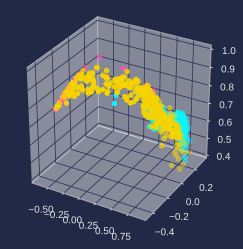

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 434ms/step - loss: 0.1964 - val_loss: 0.2429
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 0.380726327637901


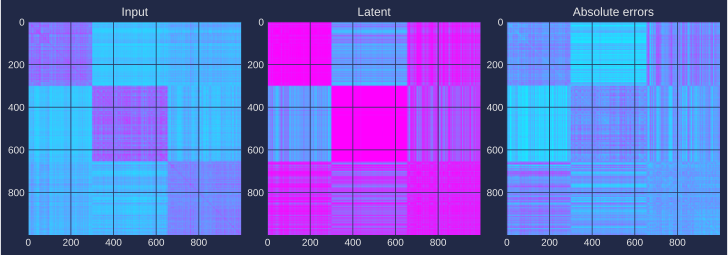

In [18]:
model = Sequential([
    Input(shape=(784,)),
    Dense(784 // 2,  activation="relu"),
    Dense(784 // 4,  activation="relu"),
    Dense(784 // 8,  activation="relu"),
    Dense(784 // 16, activation="relu"),
    Dense(784 // 32, activation="relu"),
    Dense(784 // 64, activation="relu"),
    Dense(3, activation="tanh"),
	# LayerNormalization(),
    UnitNormalization(-1),
])

import keras
class CustomCallback(keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        plot_scatter(self.model.predict(X))

model.compile(optimizer="adam", loss=correlation_loss)
history = model.fit(x_train, x_train, epochs=3, batch_size=2048, shuffle=True, validation_data=(x_test, x_test), callbacks=[CustomCallback()])
plot_correlation_matrices(X, model.predict(X))